In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.stats.mstats import mquantiles
import pandas as pd
import pdb

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
# Import custom quantile regression models from the mfpi folder
import sys
sys.path.append("../")
from mfpi import qr_models as qr

## Data set

In this workbook, we will use a data set about blog posts.
This dataset was taken from the UCI Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/BlogFeedback).

The task associated with the data is the prediction of the number of comments in the upcoming 24 hours.
In order to simulate this situation, we choose a basetime (in the past) and select the blog posts that were published at most 72 hours before the selected base date/time.
Then, we calculate all the features of the selected blog posts from the information that was available at the basetime, therefore each instance corresponds to a blog post.
The target is the number of comments that the blog post received in the next 24 hours relative to the basetime.

In the data loaded below, the basetimes were in the years 2010 and 2011. 

In [3]:
dataset_full = pd.read_csv('../data/blogData_train.csv', header=None)
dataset_full

,0,1,2,3,4,5,6,7,8,9,...,271,272,273,274,275,276,277,278,279,280
0,40.30467,53.845657,0.0,401.0,15.0,15.52416,32.441880,0.0,377.0,3.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,40.30467,53.845657,0.0,401.0,15.0,15.52416,32.441880,0.0,377.0,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,40.30467,53.845657,0.0,401.0,15.0,15.52416,32.441880,0.0,377.0,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,40.30467,53.845657,0.0,401.0,15.0,15.52416,32.441880,0.0,377.0,3.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,40.30467,53.845657,0.0,401.0,15.0,15.52416,32.441880,0.0,377.0,3.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52392,33.00000,0.000000,33.0,33.0,33.0,11.00000,15.556349,0.0,33.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52393,33.00000,0.000000,33.0,33.0,33.0,11.00000,15.556349,0.0,33.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52394,0.00000,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52395,0.00000,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


This data set is a bit too large to conveniently run in this tutorial. So, let's make it smaller.

In [4]:
from sklearn.model_selection import train_test_split

# Throw away most of the data to speed things up
_, dataset = train_test_split(dataset_full, test_size=1000, random_state=2023)

## Make a test set

We consider the problem of predicting Y | X.

We will hold out some of the observations for testing.

In [5]:
# Set a random seed for reproducibility
np.random.seed(2023)

# Designate a test set
X_data, X_test, Y_data, Y_test = train_test_split(dataset.iloc[:,0:280].values, dataset.iloc[:,-1].values, test_size=0.2, random_state=2023)

print("Number of explanatory variables: {:d}.".format(X_data.shape[1]))
print("Number of data points: {:d}.".format(X_data.shape[0]))
print("Number of test points: {:d}.".format(len(Y_test)))

Number of explanatory variables: 280.
Number of data points: 800.
Number of test points: 200.


Most blog receive few or no comments.

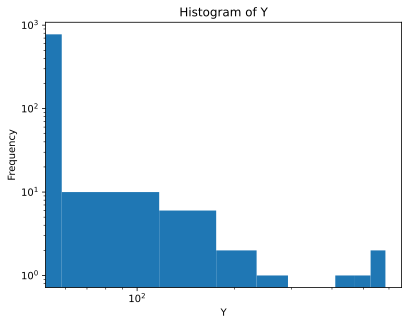

In [6]:
plt.hist(Y_data)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Y")
plt.ylabel("Frequency")
plt.title("Histogram of Y")
plt.show()

## Machine learning predictions

We can try to predict Y | X using a deep neural network.

In [7]:
# Initialize the deep neural network
from mfpi.deep_regression import Net as PyTorchNet

black_box = PyTorchNet(X_data.shape[1], dropout=0, learning_rate=0.01,
                       num_epochs=1000, batch_size=256, num_hidden=256, random_state=2023)

100%|██████████| 1000/1000 [00:10<00:00, 92.46it/s]


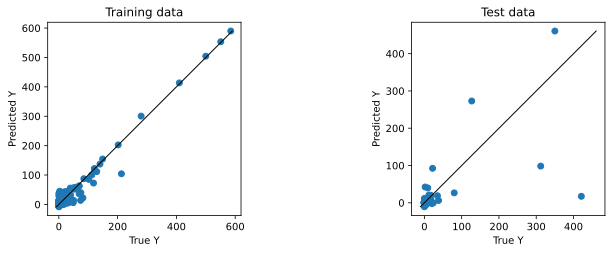

In [8]:
# Fit the black-box model on all data points
black_box.fit(X_data, Y_data)

# Make predictions on test data
Y_hat = black_box.predict(X_test)
Y_hat_train = black_box.predict(X_data)

# Compare test points to predicted values
plt.figure(figsize=(12,3.5))

plt.subplot(1, 2, 1)
y_min = np.minimum(np.min(Y_hat_train),np.min(Y_data))
y_max = np.maximum(np.max(Y_hat_train),np.max(Y_data))
plt.plot([y_min, y_max], [y_min, y_max], color = 'black', linewidth = 1)
plt.scatter(Y_data, Y_hat_train)
plt.axis('square')
plt.xlabel("True Y")
plt.ylabel("Predicted Y")
plt.title("Training data")

plt.subplot(1, 2, 2)
y_min = np.minimum(np.min(Y_hat),np.min(Y_test))
y_max = np.maximum(np.max(Y_hat),np.max(Y_test))
plt.plot([y_min, y_max], [y_min, y_max], color = 'black', linewidth = 1)
plt.scatter(Y_test, Y_hat)
plt.axis('square')
plt.xlabel("True Y")
plt.ylabel("Predicted Y")
plt.title("Test data")

plt.show()

Comparison of in-sample and out-of-sample residuals.

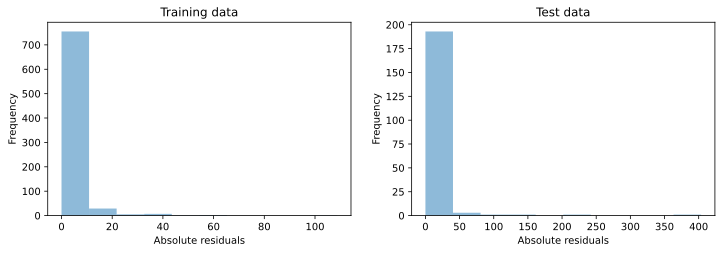

In [9]:
# Compute residuals on data and test data
residuals_data = Y_data - black_box.predict(X_data)
residuals_test = Y_test - black_box.predict(X_test)

# Plot the absolute residuals
plt.figure(figsize=(12,3.5))

plt.subplot(1, 2, 1)
plt.hist(np.abs(residuals_data), alpha=0.5, bins=10)
plt.xlabel("Absolute residuals")
plt.ylabel("Frequency")
plt.title("Training data")
plt.subplot(1, 2, 2)

plt.hist(np.abs(residuals_test), alpha=0.5, bins=10)
plt.xlabel("Absolute residuals")
plt.ylabel("Frequency")
plt.title("Test data")
plt.show()

## Naive prediction intervals based on in-sample residuals

In [10]:
def naive_prediction_intervals(X, Y, X_test, black_box, alpha):
    """
    Compute naive prediction bands based on the distribution of
      residuals within the training data set
      
    Input
    X         : n x p data matrix of explanatory variables
    Y         : n x 1 vector of response variables
    X_test    : n x p test data matrix of explanatory variables
    black_box : sklearn model object with 'fit' and 'predict' methods
    alpha     : 1 - target coverage level 
    """
    
    # Output placeholder
    lower = None
    upper = None
    
    # Fit the black box model on the training data
    black_box.fit(X, Y)
    
    # Compute residuals on the training data
    residuals_calib = np.abs(Y - black_box.predict(X))
    
    # Compute suitable empirical quantile of absolute residuals
    n_calib = len(Y)
    level_adjusted = 1.0-alpha
    Q_hat = mquantiles(residuals_calib, prob=level_adjusted)[0]
    
    # Construct prediction bands
    Y_hat = black_box.predict(X_test)
    lower = Y_hat - Q_hat
    upper = Y_hat + Q_hat
    
    return lower, upper 

In [11]:
def evaluate_predictions(lower, upper, X, Y, verbose=True):
    """
    Evaluate performance metrics for a set of regression predictions
    Computes:
    - marginal coverage
    - average size of sets
    
    Input
    lower     : n x 1 vector of prediction lower bounds
    upper     : n x 1 vector of prediction upper upper
    X         : n x p data matrix of explanatory variables
    Y         : n x 1 vector of response variables
    """
    
    # Number of samples
    n = len(Y)
    
    # Evaluate the empirical coverage
    covered = (Y>=lower) * (Y <= upper)

    # Compute marginal coverage
    marginal_coverage = np.mean(covered)
    
    # Compute average size of prediction sets
    size = np.mean(upper-lower)
    
    # Compute average size of prediction sets that contain the true label
    idx_cover = np.where(covered)[0]
    size_cover = np.mean(upper[idx_cover]-lower[idx_cover])
    
    # Print summary
    if verbose:
        print('Marginal coverage       : {:2.3%}'.format(marginal_coverage))
        print('Average length          : {:2.3f}'.format(size))
        
    return marginal_coverage, size

In [12]:
# Desired coverage level (1-alpha)
alpha = 0.1

# Apply split conformal
lower, upper = naive_prediction_intervals(X_data, Y_data, X_test, black_box, alpha)

# Evaluate the predictions
metrics = evaluate_predictions(lower, upper, X_test, Y_test)

100%|██████████| 1000/1000 [00:11<00:00, 85.33it/s]

Marginal coverage       : 90.500%
Average length          : 24.433


## Conformal prediction via conditional mean regression

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

# Choose a black-box machine learning model (1,2,3,4,5)
bb_model_index = 1

if bb_model_index==1:
    # Random forest
    black_box = RandomForestRegressor(n_estimators=100, min_samples_split=10, random_state=2023)
elif bb_model_index==2:
    # Random forest with more aggressive splits
    black_box = RandomForestRegressor(n_estimators=100, min_samples_split=1, random_state=2023)
elif bb_model_index==3:
    # Support vector machine
    black_box = SVR(kernel='rbf', degree=3)
elif bb_model_index==4:
    # Standard scikit-learn neural network
    black_box = MLPRegressor(hidden_layer_sizes=(200,), max_iter=1000, random_state=2023)
elif bb_model_index==5:
    # Custom PyTorch neural network
    black_box = PyTorchNet(X_data.shape[1], dropout=0, learning_rate=0.01,
                           num_epochs=1000, batch_size=256, num_hidden=256, random_state=2023)
else:
    print("Error: unknown machine learning model")
    black_box = None

In [18]:
def conformal_prediction_intervals(X, Y, X_test, black_box, alpha, random_state=2023):
    """
    Compute conformal prediction bands
    
    Input
    X         : n x p data matrix of explanatory variables
    Y         : n x 1 vector of response variables
    X_test    : n x p test data matrix of explanatory variables
    black_box : sklearn model object with 'fit' and 'predict' methods
    alpha     : 1 - target coverage level 
    """
    
    # Output placeholder
    lower = None
    upper = None
    
    # Split the data into training and calibration sets
    X_train, X_calib, Y_train, Y_calib = train_test_split(X, Y, test_size=0.5, random_state=2023)
    
    # Fit the black box model on the training data
    """TODO: write your code here (1 line)"""
    black_box.fit(X_train, Y_train)

    
    # Compute residuals on the calibration data
    """TODO: write your code here (1 line)"""
    residuals_calib = np.abs(Y_calib - black_box.predict(X_calib))

    
    # Compute suitable empirical quantile of absolute residuals
    """TODO: write your code here (3 lines)"""
    n_calib = len(Y_calib)
    level_adjusted = 1.0-alpha
    Q_hat = mquantiles(residuals_calib, prob=level_adjusted)[0]
    
    # Construct prediction bands
    """TODO: write your code here (3 lines)"""
    Y_hat = black_box.predict(X_test)
    lower = Y_hat - Q_hat
    upper = Y_hat + Q_hat
    
    return lower, upper  

In [19]:
# Desired coverage level (1-alpha)
alpha = 0.1

# Apply split conformal
lower, upper = conformal_prediction_intervals(X_data, Y_data, X_test, black_box, alpha)

# Evaluate the predictions
metrics = evaluate_predictions(lower, upper, X_test, Y_test)

Marginal coverage       : 89.500%
Average length          : 37.566


## Conformal prediction via quantile regression

Alternatively, we already know how to construct predictive intervals with valid marginal coverage using CQR.

In [20]:
from mfpi.deep_quantile_regression import QNet as PyTorchQNet

# Choose a black-box quantile regression model (1, 2, or 3)
bb_qr_model_index = 3

alpha = 0.1

if bb_qr_model_index==1:
    # Linear quantile regression model
    black_box_qr = qr.LinearQR(alpha=0.1)
elif bb_qr_model_index==2:
    # Quantile random forest
    black_box_qr = qr.RFQR()
elif bb_qr_model_index==3:   
    # Quantile neural network
    black_box_qr = PyTorchQNet([alpha/2,1-alpha/2], X_data.shape[1], no_crossing=True, 
                               dropout=0, learning_rate=0.01,
                               num_epochs=1000, batch_size=256, num_hidden=256, random_state=2023, 
                               calibrate=0, progress=True, verbose=False)
else:
    print("Error: unknown quantile regression model")
    black_box_qr = None

In [22]:
from sklearn.model_selection import train_test_split

def cqr_prediction_intervals(X, Y, X_test, black_box, alpha, random_state=2023):
    """
    Compute split-conformal quantile regression prediction bands.
    Uses quantile random forests as a black box 
    
    Input
    X         : n x p data matrix of explanatory variables
    Y         : n x 1 vector of response variables
    X_test    : n x p test data matrix of explanatory variables
    black_box : quantile regression model object with 'fit' and 'predict' methods
    alpha     : 1 - target coverage level 
    """
    
    # Output placeholder
    lower = None
    upper = None
    
    # Split the data into training and calibration sets
    """TODO: write your code here (1 line)"""
    X_train, X_calib, Y_train, Y_calib = train_test_split(X, Y, test_size=0.5, random_state=2023)
    
    # Fit the quantile regression model
    """TODO: write your code here (1 line)"""
    black_box.fit(X_train, Y_train)

    # Estimate conditional quantiles for calibration set
    """TODO: write your code here (1 line)"""
    lower_qr, upper_qr = black_box.predict(X_calib)

    
    # Compute conformity scores on the calibration data
    """TODO: write your code here (1 line)"""
    residuals_calib = np.maximum(Y_calib - upper_qr, lower_qr - Y_calib)

    
    # Compute suitable empirical quantile of absolute residuals
    """TODO: write your code here (3 lines)"""
    n_calib = len(Y_calib)
    level_adjusted = (1.0-alpha)  #* (1+ 1/ len(Y))
    Q_hat = mquantiles(residuals_calib, prob=level_adjusted)[0]
    
    # Construct prediction bands
    """TODO: write your code here (3 lines)"""
    lower_test, upper_test = black_box.predict(X_test)
    lower = lower_test - Q_hat
    upper = upper_test + Q_hat
    
    return lower, upper 

In [23]:
# Desired coverage level (1-alpha)
alpha = 0.1

# Apply quantile regression split conformal
lower, upper = cqr_prediction_intervals(X_data, Y_data, X_test, black_box_qr, alpha)

# Evaluate performance of predictions
metrics = evaluate_predictions(lower, upper, X_test, Y_test)

100%|██████████| 1000/1000 [00:06<00:00, 163.43it/s]

Marginal coverage       : 93.000%
Average length          : 14.971


## Numerical experiments

We will now repeatedly apply the two methods described above to the data set, each time using a different random subset of the data for testing.

In [24]:
# Choose a black-box machine learning model (1,2,3,4)
bb_model_index = 1

if bb_model_index==1:
    # Random forest
    black_box = RandomForestRegressor(n_estimators=100, min_samples_split=10, random_state=2023)
elif bb_model_index==2:
    # Random forest with more aggressive splits
    black_box = RandomForestRegressor(n_estimators=100, min_samples_split=1, random_state=2023)
elif bb_model_index==3:
    # Support vector machine
    black_box = SVR(kernel='rbf', degree=3)
elif bb_model_index==4:
    # Standard scikit-learn neural network
    black_box = MLPRegressor(hidden_layer_sizes=(200,), max_iter=1000, random_state=2023)
elif bb_model_index==5:
    # Custom PyTorch neural network
    black_box = PyTorchNet(X_data.shape[1], dropout=0, learning_rate=0.01,
                           num_epochs=1000, batch_size=256, num_hidden=256, progress=False, verbose=False, random_state=2023)
else:
    print("Error: unknown machine learning model")
    black_box = None

In [25]:
# Choose a black-box quantile regression model (1, 2, or 3)
bb_qr_model_index = 2

alpha = 0.1

if bb_qr_model_index==1:
    # Linear quantile regression model
    black_box_qr = qr.LinearQR(alpha=0.1)
elif bb_qr_model_index==2:
    # Quantile random forest
    black_box_qr = qr.RFQR()
elif bb_qr_model_index==3:   
    # Quantile neural network
    black_box_qr = PyTorchQNet([alpha/2,1-alpha/2], X_data.shape[1], no_crossing=True, 
                               dropout=0, learning_rate=0.01,
                               num_epochs=1000, batch_size=256, num_hidden=256, random_state=2023, 
                               calibrate=0, progress=False, verbose=False)
else:
    print("Error: unknown quantile regression model")
    black_box_qr = None

In [26]:
def run_experiment(dataset, black_box, black_box_qr, random_state=2023):
    # Divide data
    X_data, X_test, Y_data, Y_test = train_test_split(dataset.iloc[:,0:280].values, dataset.iloc[:,-1].values, test_size=0.2, random_state=random_state)

    
    # Run and evaluate naive
    lower_naive, upper_naive = naive_prediction_intervals(X_data, Y_data, X_test, black_box, alpha)
    metrics_naive = evaluate_predictions(lower_naive, upper_naive, X_test, Y_test, verbose=False)
    
    # Run and evaluate conformal
    lower_conformal, upper_conformal = conformal_prediction_intervals(X_data, Y_data, X_test, black_box, alpha, random_state=random_state)
    metrics_conformal = evaluate_predictions(lower_conformal, upper_conformal, X_test, Y_test, verbose=False)
    
    # Run and evaluate CQR
    lower_cqr, upper_cqr = cqr_prediction_intervals(X_data, Y_data, X_test, black_box_qr, alpha, random_state=random_state)
    metrics_cqr = evaluate_predictions(lower_cqr, upper_cqr, X_test, Y_test, verbose=False)
       
    # Return results
    results_exp = pd.DataFrame({"Method":["Naive", "Conformal", "CQR"], 
                                "Coverage":[metrics_naive[0], metrics_conformal[0], metrics_cqr[0]],
                                "Length":[metrics_naive[1], metrics_conformal[1], metrics_cqr[1]],
                  })
    
    return results_exp

In [29]:
# Run many experiments
results = pd.DataFrame()

from tqdm import tqdm

for experiment in tqdm(range(20)):
    
    # Random state for this experiment
    random_state = 2023 + experiment
    
    # Run the experiment
    result_exp = run_experiment(dataset, black_box, black_box_qr, random_state=random_state)
    
    # Store results
    results = pd.concat([results,result_exp])

results

100%|██████████| 20/20 [00:42<00:00,  2.14s/it]


,Method,Coverage,Length
0,Naive,0.865,15.045832
1,Conformal,0.895,37.566445
2,CQR,0.945,21.719000
0,Naive,0.835,11.612091
1,Conformal,0.860,20.748581
2,CQR,0.940,25.881500
0,Naive,0.880,11.685496
1,Conformal,0.935,24.993200
2,CQR,0.970,40.169000
0,Naive,0.825,10.391874


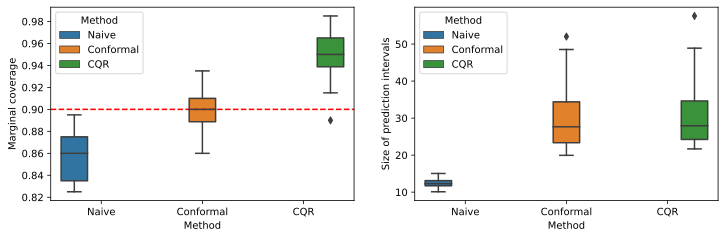

In [30]:
import seaborn as sns

# Prepare to make side-to-side plots
plt.figure(figsize=(12,3.5))

# Compare marginal coverage
plt.subplot(1, 2, 1)
ax = sns.boxplot(y="Coverage", x="Method", hue="Method", data=results)
ax.set(xlabel='Method', ylabel='Marginal coverage')
ax.axhline(1-alpha, ls='--', color="red")

# Compare average length of prediction intervals
plt.subplot(1, 2, 2)
ax = sns.boxplot(y="Length", x="Method", hue="Method", data=results)
ax.set(xlabel='Method', ylabel='Size of prediction intervals')
plt.show()